## Wikidpedia Page Views and Signal Processing of Time Series
### by Daniel, modifed from my Meetup presentation for Kahuna
### Original notebook at: http://bit.ly/1PgF3wq
<center><img src="kahuna_daily_views.png"></center>

This notebook uses Wikipedia page views as a souce of time series data. The reason I'm so interested in WP, is that it may be a proxy for other other media channel interest. 

For instance, what has been the national interest on the cancer treatment drug Tarceva. It's difficult to get a long history consumer of content from Twitter, Youtube, Facebook, etc. Wikipedia offers a full seven years of basic usage stats. 

I have three goals with this notebook:

* Show how to pull view data from Wikipedia
* Provide examples of signal processing of time series 
* Understand the behavior of Wikipedia users (content viewers)

In addition, the contributor's stats on edits is available. That also might yield some interesting analysis. For instance the page maintainers for a drug, might well be a key influencer in the field. Or, the time series data
which belongs to an editor, might be used as a co-variate to be removed. Perhaps the amount of time a competitor company puts into their WP article will provide insight for a client.

#### For now, let's restrict ourselves to page views.

**CONTENTS**

* <a href='#core logic'>Core Logic To Download View Stats</a>
* <a href='#kahuna_stats'>Getting Kahuna Stats</a>
 * <a href='#time series monthly'>Monthly Time Series</a>
 * <a href='#covariates'>Gathering Covariates</a>
 * <a href='#correlation'>Correlation</a>
 * <a href='#fft'>FFT</a>
* <a href='#peaks'>Identifying Peaks</a>
* <a href='#random'>Random Sample</a>
 * <a href='#weighted average'>Weighted Average</a>

## Version Information

Matplotlib 1.5.0 has a bug which broke the time series plotting.
Down grading to 1.4.0 also appeared to require Pandas to downgrade to 0.16.2 from 0.17.0 
This needs further investigation.

In [1]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib,statsmodels


numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0
statsmodels 0.6.1


## Core Methods for Downloading and Plotting
<a id='core logic'></a>

In [209]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')
        self.try_max = 3
        self.show_url_fails = False
        
    def _get_data(self, url, try_num):
        if try_num > self.try_max:
            print "reached max try's"
            return None
        try:
            response = urllib2.urlopen(url)
            out = response.read()
            return out
        except urllib2.HTTPError:
            sleep(5)
            try_num += 1
            if self.show_url_fails:
                print "try again:%i:%s" %(try_num, url)
            self._get_data(url, try_num)
        
    def loop_over_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
            try:
                try_num = 0
                out = self._get_data(url, try_num) 
                if out is None:
                    continue

            except Exception, err: # modicum of trouble shooting
                print err          # mystery failures
                continue
                #raise Exception
                
            out = json.loads(out) # first column happens to be a date string, which will become the index
            df = pd.DataFrame(out) 
            
            DF = DF.append(df)
            DF = DF.reindex(fill_value=0) # make sure that all days are filled for later comparison
        
        DF['date'] = DF.index # useful when loading the data from csv file
        return DF
    
    @classmethod # shouldn't need class instance for this but it nice to keep organized in one place
    def plot_time_series(self, df, norm=False, interval=2):
        '''Plot time series average per month and print labels '''
        grp = df.groupby('month')
        y = grp.sum()
        
        if 'daily_views' in y.keys(): # case when df is a single output of loop_over_dates
            y = y['daily_views']
        else:                         # case for df concatenation
            pass
        
        if norm:
            y /= np.std(y, axis=0)                
            
        plt.plot(y)      
        plt.grid(True)
        plt.title("Daily Views Summed Over Months", fontsize=15)
        plt.ylabel("Views per month", fontsize=15)
        plt.xlabel("Date", fontsize=15)
        #plt.xlim(0, len(y))
        
        labels = df.month.unique()
        labels = labels[0::interval]
        
        n = np.arange(len(y))[0::interval]
        plt.xticks(n, labels, rotation=45)  
                    
    @classmethod                
    def fft(self, data, norm=False):
        '''Plot FFT using Welch's method, daily resolution '''
        #plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=50, noverlap=25, nfft=264, scaling='spectrum', detrend="linear")
        
        if norm:
            y /= np.std(y, axis=0)     
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Wiki Views")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

## Getting the Kahuna Stats
<a id='kahuna_stats'></a>

In [3]:
# setup constants for dates of the query 
start = '1/1/2011' # from techcrunch.com
end = '12/1/2015'

In [251]:
wv = WikiViews("Kahuna_(company)", start, end )
kah = wv.loop_over_dates()

In [142]:
print kah.tail()

            daily_views   month project  rank             title        date
2015-11-22            2  201511      en    -1  Kahuna_(company)  2015-11-22
2015-11-23            2  201511      en    -1  Kahuna_(company)  2015-11-23
2015-11-24           11  201511      en    -1  Kahuna_(company)  2015-11-24
2015-11-25            2  201511      en    -1  Kahuna_(company)  2015-11-25
2015-11-26            7  201511      en    -1  Kahuna_(company)  2015-11-26


## Time Series
The data is returned on a daily basis. I don't think that is very useful for a first look. Most people want to see the trend. We should keep in mind, that WP's user's have grown over the years and that may account for some trending. We'll use signal processing techniques later that will account for that.
<a id='time series monthly'></a>

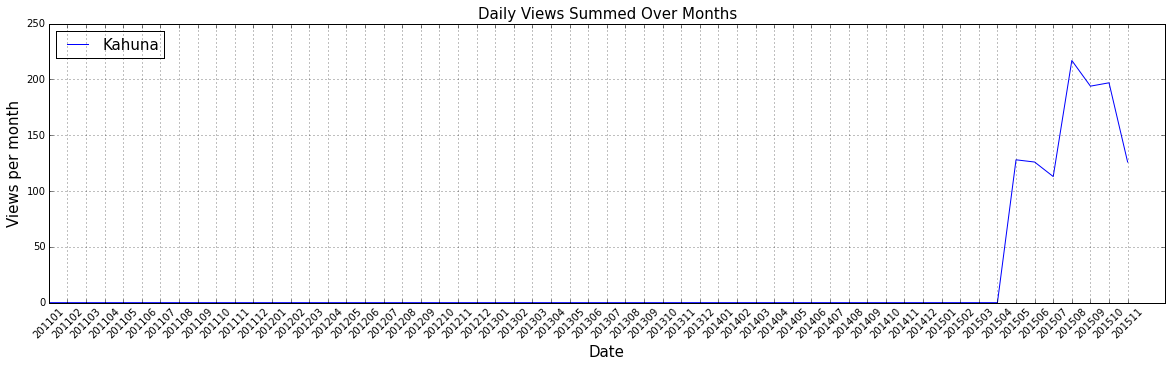

In [143]:
WikiViews.plot_time_series(kah, interval=1)
plt.legend((["Kahuna"]), loc="upper left", fontsize=15) 

Adjust our plot. 

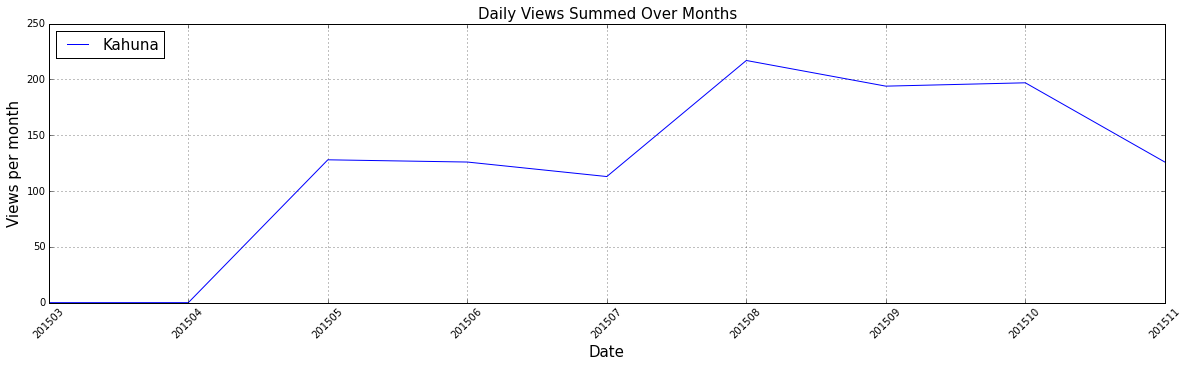

In [252]:
WikiViews.plot_time_series(kah[-250:], interval=1)
plt.legend((["Kahuna"]), loc="upper left", fontsize=15) 

## Covariates
<a id='covariates'></a>

We'd like to be able to know what high level topics influence the interest in Kahuna.
We'll look for covariates and try to come up with some entry point ideas that we would present to a domain
export or analyst.

In [145]:
wv = WikiViews("Mobile_marketing_automation", start, end )
mob_mar_aut = wv.loop_over_dates()

In [12]:
wv = WikiViews("Marketing_automation", start, end)
mar_auto = wv.loop_over_dates()

In [16]:
kah['date'] = kah.index
df = pd.concat({'date':kah.date,
                'month':kah.month, 
                'kah':kah.daily_views, 
                'mob_mar_aut':mob_mar_aut.daily_views,
                'mar_auto':mar_auto.daily_views,
               }, axis=1)

df.to_csv("kahuna_and_cov_views.csv", index=False)

I kept coming back to this notebook for work on it and didn't want to wait for the data to download.
Below I'm loading it back from a csv file.

In [146]:
df = pd.read_csv("kahuna_and_cov_views.csv")
df.set_index("date", drop=True, inplace=True)
df.head()

,kah,mar_auto,mob_mar_aut,month
date,,,,
2011-01-01,0,13,0,201101
2011-01-02,0,11,0,201101
2011-01-03,0,45,0,201101
2011-01-04,0,50,0,201101
2011-01-05,0,53,0,201101


Examine for correlation by eye. We need to normalize to correct for scale. Note, the y label units will not be 
applicable for this plot.

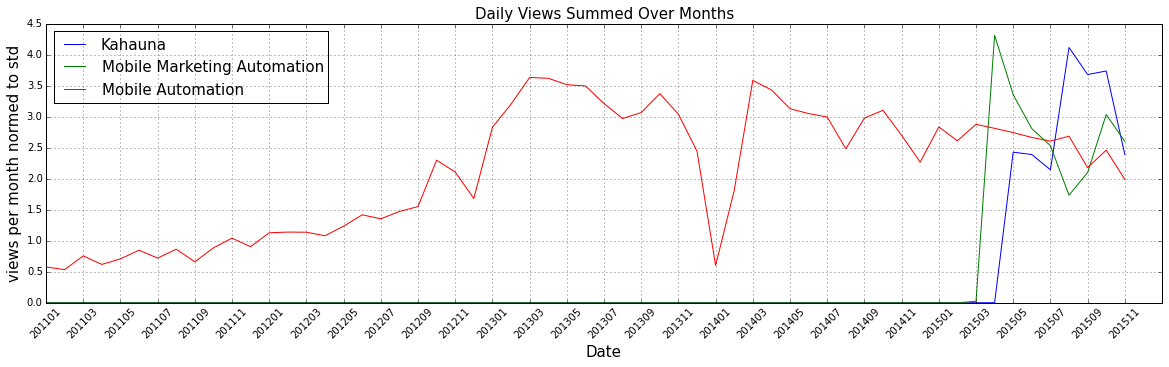

In [147]:
WikiViews.plot_time_series(df[['kah', 'mob_mar_aut', 'mar_auto', 'month']], norm=True)
plt.legend(('Kahuna', 'Mobile Marketing Automation', 'Mobile Automation'), loc="upper left", fontsize=15)
plt.ylabel("views per month normed to std")

## Correlation
<a id='correlation'></a>

Recall, this is just a very basic exercise. We are using really obviously connected information to form a quick and dirty report suitable for an analysis to look at on day one of a project. We will need to search more for data which could be used to predict.

Examination by eye of the above plots, looks like all 4 topics are roughly correlated in time.
It's good to get a quantifier though. Tarceva and Lung Cancer have a relatively small correlation compared to EGFR.




In [148]:
df[['kah', 'mob_mar_aut', 'mar_auto']].corr()

,kah,mob_mar_aut,mar_auto
kah,1.000000,0.358400,0.112483
mob_mar_aut,0.358400,1.000000,0.109304
mar_auto,0.112483,0.109304,1.000000


# Moving on with numerical analysis techniques
##  Filtering and FFT
<a id='fft'></a>

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

Below is the time series by day, rather than by monthly sum as it was above.

## I redefine the times series to the last 200 points where the data appears to begin.

In [229]:
kah = df.kah[-200:]
kah.shape

(200,)

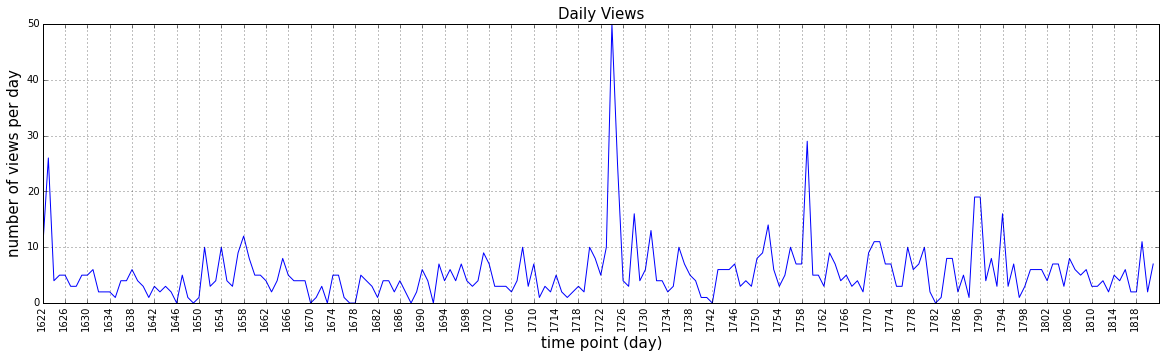

In [230]:
plt.plot(kah)
plt.grid(True)
plt.title("Daily Views", fontsize=15)
plt.ylabel("number of views per day", fontsize=15)
plt.xlabel("time point (day)", fontsize=15)
labels = df.index[-200:][0::4]
n = np.arange(len(kah))[0::4]
plt.xticks(n, labels, rotation='vertical');

Now the frequency analysis. Note that in the Welch's function which produces this plot, the detending feature is set to _linear_. Welch's is using 50 data points per segment. That means the FFT is happening over an average of 4 segments with an overlap of 50% and zero filled ( interpolated ) to 264 points to make it smoother.

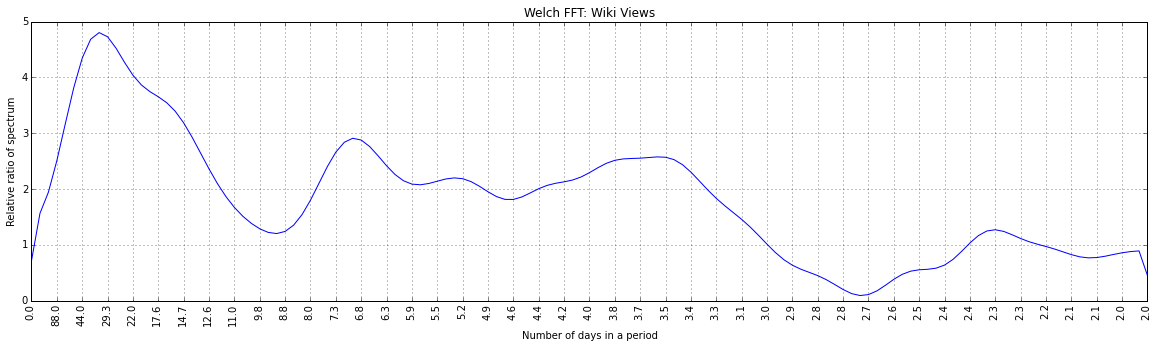

In [231]:
f, y, frq = WikiViews.fft(kah)

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. 

The next step would be to look for covarites to explain the time series and the periodicity. 

## Find peaks
<a id='peaks'></a>

### The Savitzky-Golay filer was taken from here:

http://wiki.scipy.org/Cookbook/SavitzkyGolay


In [38]:
from math import factorial

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    # usage and comments removed for brevity see the cookbook link for details
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))

    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")

    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")

    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order+1)
    half_window = (window_size -1) // 2

    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)

    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])

    y = np.concatenate((firstvals, y, lastvals))

    return np.convolve( m[::-1], y, mode='valid')

This function is just an implementation of the first and second derivative tests.

In [39]:
def peak_detection(data):
    der1 = savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

Finding peaks is more useful when analyzing an FFT output.

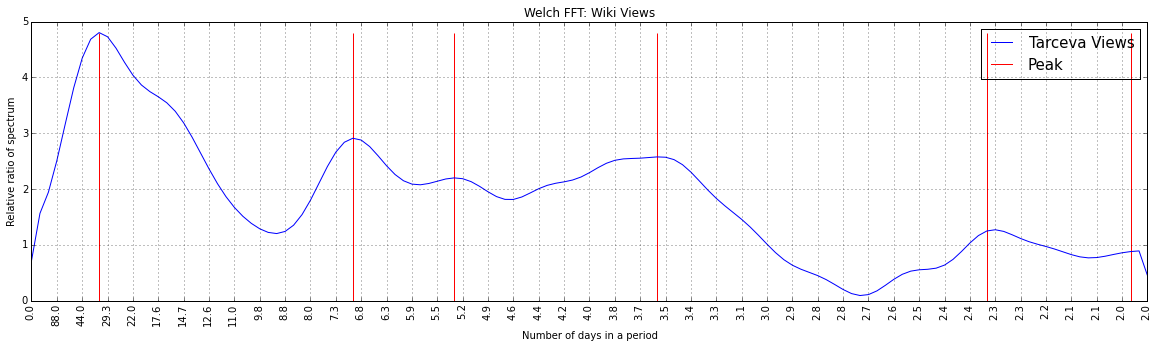

In [232]:
peaks = peak_detection(y)
plt.figure()
freq, y, frqs = WikiViews.fft(kah)
plt.vlines(freq[peaks], 0, y.max(), 'r')
plt.legend(('Tarceva Views', 'Peak'), fontsize=15)

## Print the periods of interest

In [167]:
def print_fft_periods(fp):
    p = np.round(1/fp, decimals=1)
    pp = " days\n ".join(map(str, p))
    print "The periods of interest are:\n%s days" %pp


In [168]:
print_fft_periods(fp)

The periods of interest are:
33.0 days
 6.9 days
 3.6 days


## Understanding Wikipedia Trends  Using Random Pages
<a id='random'></a>

I'd like to see if there's a general viewing trend with Wikipedia. To do that, I'll need to select pages at random.
Mediawiki has an api for that and there's a button on the Wikipedia homepage. 

_I didn't realize there is a rest api for Wikipedia before I wrote this. I'm leaving it in place since it's a decent regex hack._

In [49]:
import re
obj = re.compile(r'"wgPageName":"(?P<name>\w.*?")') 

def get_random_name():
    random = 'https://en.wikipedia.org/wiki/Special:Random'
    response = urllib2.urlopen(random)
    src_out = response.read()
    response.close()
    
    match = obj.search(src_out)
    #"wgPageName":"foo_bar_bash"
    if match:
        page_name = match.group('name')
        return page_name.replace('"','') # hack to fix above hack
    else:
        return None # handles the case when the page name is not the same as the stats page name

Not all topics have the same length of history. That will cause problems.
Let's build a collection of random page though and deal with it. In fact I think a linear weight will handle that bias.

The other bias I know for certain, is that not all the Wikipedia page view stat pages are named after the
normal article page. I'll wager that will bias this experiment in some messed up way. 

This is still really a first iteration so I'm not going to try and fix everything.

In [51]:
def get_random_data(df):
    rand_page = get_random_name()
    print rand_page
    if rand_page is not None:
        wv = WikiViews(rand_page, start, end)
        rand_data = wv.loop_over_dates()
        df[rand_page] = rand_data['daily_views']

    return df

I tried 20 to test things out. 100 or more would be better.

In [53]:
for i in range(20):
    try:
        df = get_random_data(df)
    except KeyboardInterrupt:
        # killing the loop saves the data we have already
        df.to_csv("wiki_views_random_data.csv", index=False)
        raise KeyboardInterrupt
        
df.to_csv("wiki_views_random_data.csv", index=False)

Spittoono
Weightlifting_at_the_2004_Summer_Olympics_–_Men's_69_kg
Florian_Latorre
Cauffry
Labour_for_Independence
Jude_Dibia
1947_Arkansas_Razorbacks_football_team
Anikey_Stroganov
Umberto_Tirelli
Tylotiella_basipunctata
The_Zero_Hour_(1939_film)
John_Ibrahim_(footballer)
Iwate_Nippo
Spencer_Frankl
Sign_name
List_of_listed_buildings_in_South_Knapdale,_Argyll_and_Bute
WKAK
Municipal_Golf_Course
Sandra_Pisani
Padma_Samten


In [213]:
df = pd.read_csv("wiki_views_random_data.csv")
df.shape #sanity check

(1822, 24)

### Weighted Average Of Random Time Series
<a id='weighted average'></a>

We still would prefer a method that will deal with the different lenghts of the time series.
For that will use a linear weight. The more points, the higher the weight in the average.

We'll need to interpolate the missing points first. This won't affect the long leading zeros **much**. 

In [203]:
def interp(col):
    z = np.where(col == 0)[0]
    num = np.nonzero(col)[0]
    if len(z) < 1 or len(num) < 1:
        return col
    col[z] = np.interp(z, num, col[num])
    return col

def process_for_ave_fft(df):
    arr = df.drop("month", axis=1, inplace=False).as_matrix()
    arr = arr.astype(np.float32)
    range_ = arr.max(axis=0, keepdims=True) - arr.min(axis=0, keepdims=True)
    arr /= range_
    arr = np.nan_to_num(arr) 

    num_non_zeros = map(lambda x:len(np.where(x != 0)[0]), arr.T) # map iterates on rows
    total_points = np.sum(num_non_zeros)

    for i in range(arr.shape[1]):
        arr[:,i] = interp(arr[:,i])
    
    w = num_non_zeros / np.float32(total_points)
    ave_arr = np.average(arr, axis=1, weights=w)
    
    return ave_arr

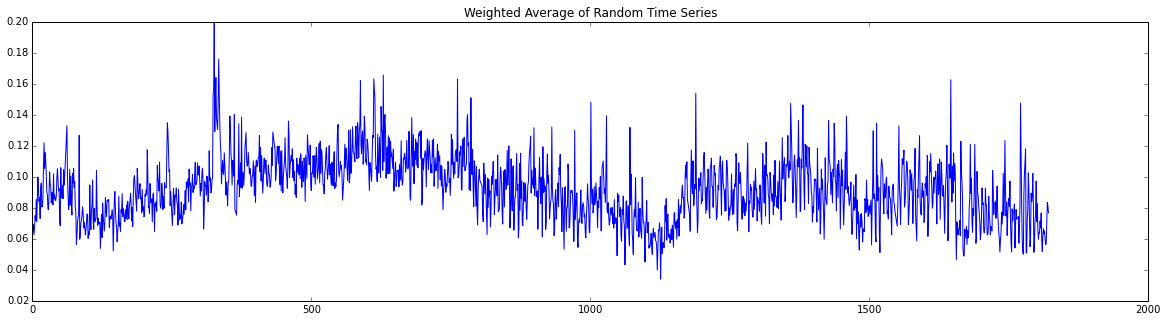

In [204]:
ave_arr = process_for_ave_fft(df)
plt.plot(ave_arr)
plt.title("Weighted Average of Random Time Series")

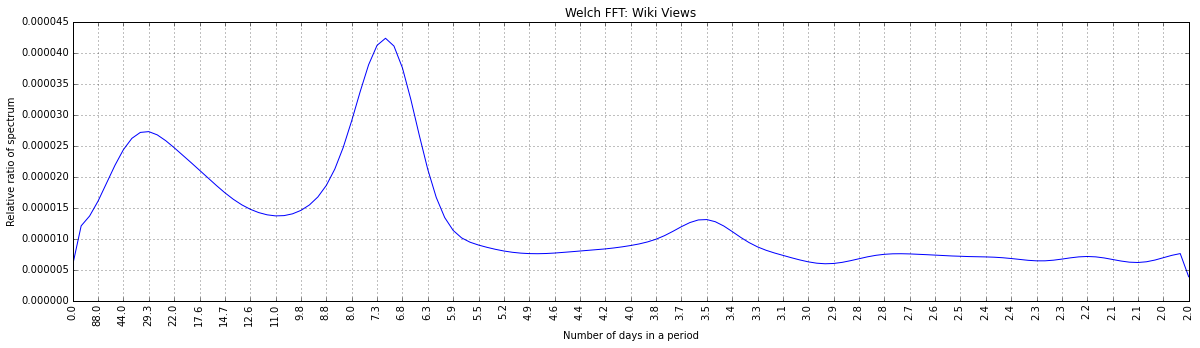

In [206]:
WikiViews.fft(ave_arr);

The average random Wikipedia page is viewed heavily on a 7 and 30 day period.
That doesn't mean we wouldn't target our own viewers on the same schedule, but if we want to see how Kahuna
is being viewed against this trend, we should "regress out" the confound.


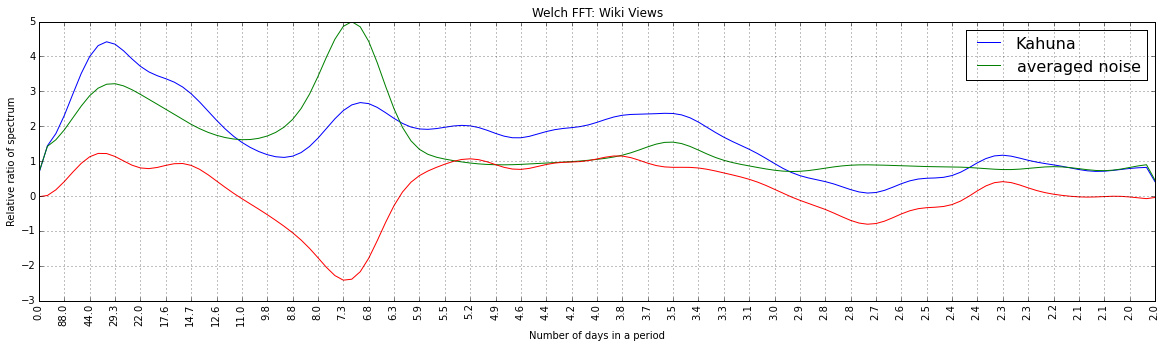

In [250]:
f, yk, _ = WikiViews.fft(kah, norm=True)
_, ya, _ = WikiViews.fft(ave_arr, norm=True)
plt.legend(('Kahuna', 'averaged noise', 'delta'), fontsize=16)
plt.grid(True)
delta = yk - ya
plt.plot(f, delta)